# Adaptive conformal inference under distribution shift

Adaptive Conformal Inference (ACI) [[Gibbs et al., 2021](https://proceedings.neurips.cc/paper/2021/hash/0d441de75945e5acbc865406fc9a2559-Abstract.html)] is a method that aims at correcting the coverage of conformal prediction methods in a sequential prediction framework (e.g. time series forecasting) when the distribution of the data shifts over time. ACI can be applied on top of any conformal prediction method, for both regression and classification. In this notebook, we showcase it in combination with Conformalized Quantile Regression (CQR) [[Romano et al., 2019](https://proceedings.neurips.cc/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf)] for a stock price trend estimation task.

In [1]:
!pip install -q yfinance tabulate

## Download and prepare the data

We download the last year of daily adjusted closing stock prices for some large tech companies. We split each time series data sequentially into a training, validation and test data sets.

In [2]:
import yfinance as yf
df = yf.download(tickers = "AMZN AAPL GOOGL NFLX MSFT", period = "1y", interval = "1d", ignore_tz = True, prepost = False) 
tickers = df["Adj Close"].columns
dates = df.index
y_all = df["Adj Close"].to_numpy().T
y_all /= y_all.max(1)[:, None]

[*********************100%***********************]  5 of 5 completed


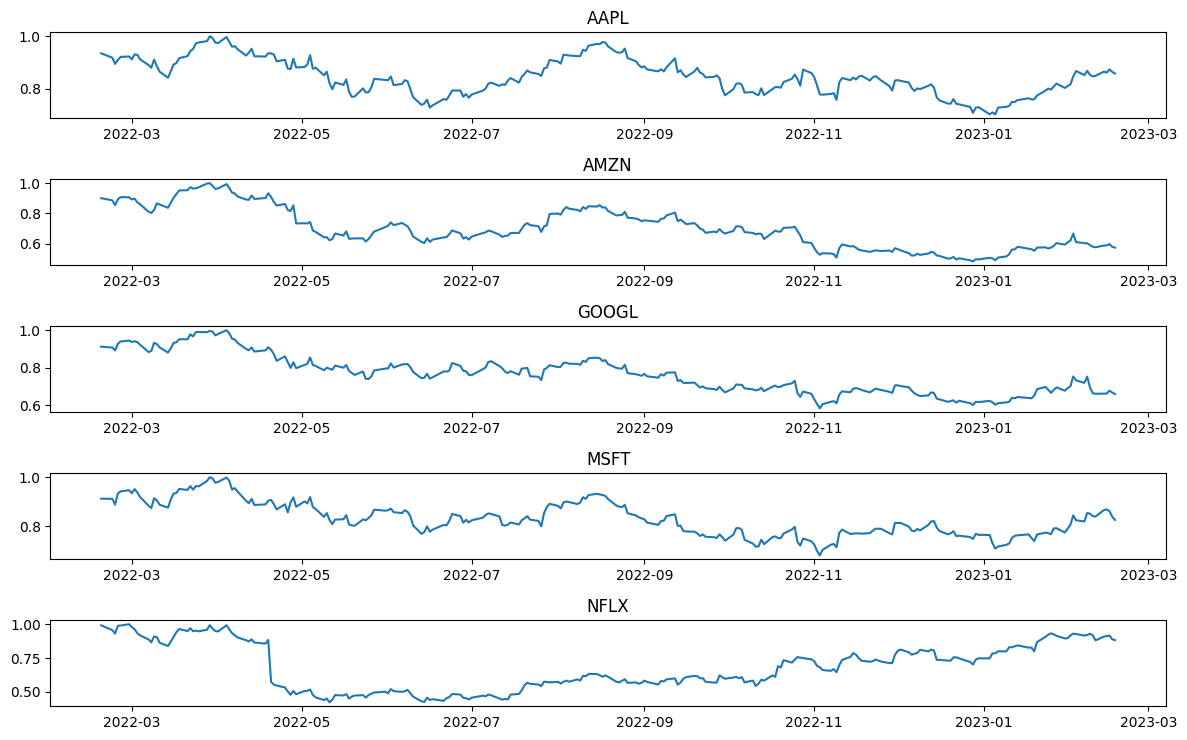

In [3]:
import matplotlib.pyplot as plt
n_tickers = len(tickers)
plt.figure(figsize=(12, 1.5 * n_tickers))
for i in range(n_tickers):
    plt.subplot(n_tickers, 1, i + 1)
    plt.plot(df.index, y_all[i])
    plt.title(tickers[i], fontsize=12)
plt.tight_layout()

In [4]:
import numpy as np
period = 60
y_train = y_all[:, :-2*period, None]
y_val = y_all[:, -2*period:-period, None]
y_test = y_all[:, -period:, None]
n_data = y_all.shape[1]
x_all = np.broadcast_to(np.linspace(0, 1, n_data), shape=y_all.shape)
x_train = x_all[:,:-2*period, None]
x_val = x_all[:, -2*period:-period, None]
x_test = x_all[:, -period:, None]

# Modelling and training

In order to capture the general trends in the data, for each time series of stock prices we build a simple quadratic model over the time steps.

In [5]:
import flax.linen as nn

class QuadraticModel(nn.Module):
    output_dim: int

    @nn.compact
    def __call__(self, x, **kwargs):
        params = self.param("coeffs", nn.initializers.zeros, (3,))
        return params[0] + params[1] * x + params[2] * x ** 2

We then use Fortuna to build a probabilistic model starting from the quadratic model, train the model for each time series of stock prices, make predictions and estimate credible intervals.

In [6]:
from fortuna.data import DataLoader
from fortuna.prob_model import ProbRegressor
from fortuna.prob_model.posterior import MAPPosteriorApproximator
from fortuna.prob_model.fit_config import FitConfig, FitOptimizer, FitMonitor
from fortuna.model import ScalarConstantModel
import optax

target_error = 0.05

n_train = y_train.shape[1]
val_cred_intervals = np.zeros((n_tickers, period, 2))
test_cred_intervals = np.zeros((n_tickers, period, 2))
test_conformal_intervals = np.zeros((n_tickers, period, 2))
train_preds, val_preds, test_preds = np.zeros((n_tickers, n_train, 1)), np.zeros((n_tickers, period, 1)), np.zeros((n_tickers, period, 1))
statuses = []

for i in range(n_tickers):
    print(f"Ticker: {tickers[i]}.")
    train_data_loader = DataLoader.from_array_data((x_train[i], y_train[i]), batch_size=128, prefetch=True)
    val_data_loader = DataLoader.from_array_data((x_val[i], y_val[i]), batch_size=128, prefetch=True)
    test_data_loader = DataLoader.from_array_data((x_test[i], y_test[i]), batch_size=128, prefetch=True)
    
    prob_model = ProbRegressor(
        model=QuadraticModel(1),
        likelihood_log_variance_model=ScalarConstantModel(output_dim=1),
        posterior_approximator=MAPPosteriorApproximator()
    )
    
    statuses.append(
        prob_model.train(
            train_data_loader=train_data_loader,
            fit_config=FitConfig(
                optimizer=FitOptimizer(method=optax.adam(1e-1), n_epochs=1000),
                monitor=FitMonitor(early_stopping_patience=2)
            )
        )
   )
    
    train_preds[i] = prob_model.predictive.mean(inputs_loader=train_data_loader.to_inputs_loader())
    val_preds[i] = prob_model.predictive.mean(inputs_loader=val_data_loader.to_inputs_loader())
    test_preds[i] = prob_model.predictive.mean(inputs_loader=test_data_loader.to_inputs_loader())
    val_cred_intervals[i] = prob_model.predictive.credible_interval(inputs_loader=val_data_loader.to_inputs_loader(), error=target_error)
    test_cred_intervals[i] = prob_model.predictive.credible_interval(inputs_loader=test_data_loader.to_inputs_loader(), error=target_error)

Ticker: AAPL.


Epoch: 1000 | loss: -253.32507: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 669.51it/s]


Ticker: AMZN.


Epoch: 1000 | loss: -209.68332: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 673.61it/s]


Ticker: GOOGL.


Epoch: 1000 | loss: -264.32507: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 670.72it/s]


Ticker: MSFT.


Epoch: 1000 | loss: -284.31036: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 671.96it/s]


Ticker: NFLX.


Epoch: 1000 | loss: -183.1714: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 658.92it/s]


Text(0.5, 1.0, 'Loss decays')

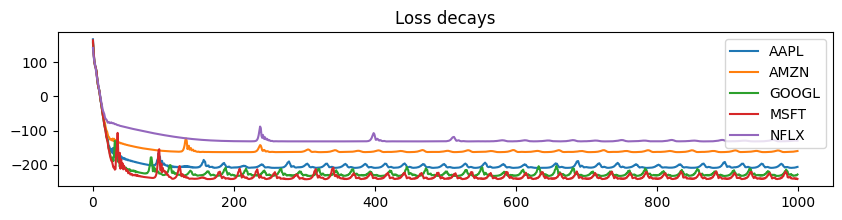

In [16]:
plt.figure(figsize=(10, 2))
for i in range(n_tickers):
    plt.plot(statuses[i]["fit_status"]["loss"])
plt.legend(tickers)
plt.title("Loss decays")

## Sequential conformal intervals

As test data points get sequentially observed, we want to build conformal intervals for the next target variables. To do this, as validation data we use estimates of credible intervals for all the data initially devoted for validation, plus the estimates of credible intervals for the test data points that have already been observed. We estimate conformal intervals in two ways: using Conformalized Quantile Regression (CQR) from [Romano et al., 2019](https://proceedings.neurips.cc/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf) and using CQR with the additional coverage error update funcionality given by Adaptive Conformal Inference (ACI) from [Gibbs et al, 2021](https://proceedings.neurips.cc/paper/2021/hash/0d441de75945e5acbc865406fc9a2559-Abstract.html).

In [7]:
from fortuna.conformal.regression import QuantileConformalRegressor, AdaptiveConformalRegressor

errors = target_error * np.ones((n_tickers, period + 1))
is_ins = np.zeros((n_tickers, period))
conformal_intervals = np.zeros((n_tickers, period, 2))
adaptive_conformal_intervals = np.zeros((n_tickers, period, 2))
qcr = QuantileConformalRegressor()
aqcr = AdaptiveConformalRegressor(conformal_regressor=qcr)

for i in range(n_tickers):
    for j in range(period):
        if j == 0:
            val_lower_bounds, val_upper_bounds = val_cred_intervals[i].T
            val_targets = np.copy(y_val[i])
        else:
            val_lower_bounds = np.concatenate((val_cred_intervals[i, :, 0], test_cred_intervals[i, :j, 0]))
            val_upper_bounds = np.concatenate((val_cred_intervals[i, :, 1], test_cred_intervals[i, :j, 1]))
            val_targets = np.concatenate((y_val[i, :], y_test[i, :j]))
            
        conformal_intervals[i, j] = qcr.conformal_interval(
            val_lower_bounds=val_lower_bounds,
            val_upper_bounds=val_upper_bounds,
            test_lower_bounds=test_cred_intervals[None, i, j, 0], 
            test_upper_bounds=test_cred_intervals[None, i, j, 1],
            val_targets=val_targets, 
            error=target_error
        )[0]

        adaptive_conformal_intervals[i, j] = aqcr.conformal_interval(
            val_lower_bounds=val_lower_bounds,
            val_upper_bounds=val_upper_bounds,
            test_lower_bounds=test_cred_intervals[None, i, j, 0], 
            test_upper_bounds=test_cred_intervals[None, i, j, 1],
            val_targets=val_targets, 
            error=errors[i, j]
        )[0]
        
        errors[i, j+1] = aqcr.update_error(
            conformal_interval=adaptive_conformal_intervals[i, j],
            error=errors[i, j],
            target=y_test[i, j],
            target_error=target_error
        )

The following plots show stock trend predictions for training, validation and test data sets for the stock prices of each company. On the left column, we visualize 95% conformal intervals obtained via CQR; on the right column, we see conformal intervals targeting 95% coverage computed using CQR in combination with ACI.

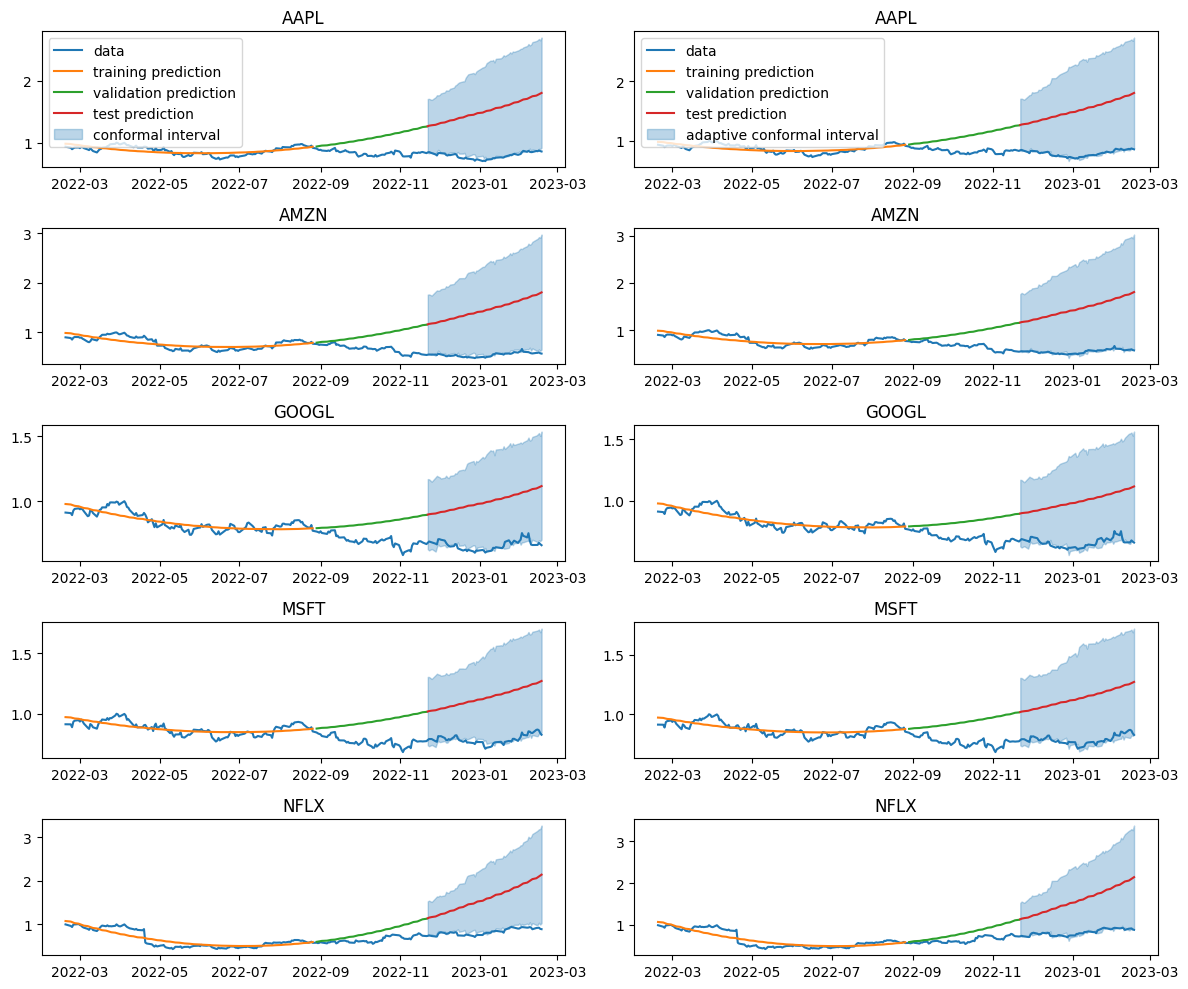

In [8]:
plt.figure(figsize=(12, 2 * n_tickers))
for i in range(n_tickers):
    plt.subplot(n_tickers, 2, 2 * i + 1)
    plt.plot(df.index, y_all[i], label="data")
    plt.plot(df.index[:n_train], train_preds[i], color="C1", label="training prediction")
    plt.plot(df.index[n_train:n_train+period], val_preds[i], color="C2", label="validation prediction")
    plt.plot(df.index[n_train+period:], test_preds[i], color="C3", label="test prediction")
    plt.fill_between(df.index[n_train+period:], *conformal_intervals[i].T, alpha=0.3, color="C0", 
                     label=f"conformal interval")
    plt.title(tickers[i], fontsize=12)
    if i == 0:
        plt.legend(loc="upper left")
    
    plt.subplot(n_tickers, 2, 2 * i + 2)
    plt.plot(df.index, y_all[i], label="data")
    plt.plot(df.index[:n_train], train_preds[i], color="C1", label="training prediction")
    plt.plot(df.index[n_train:n_train+period], val_preds[i], color="C2", label="validation prediction")
    plt.plot(df.index[n_train+period:], test_preds[i], color="C3", label="test prediction")
    plt.fill_between(df.index[n_train+period:], *adaptive_conformal_intervals[i].T, alpha=0.3, color="C0", 
                     label="adaptive conformal interval")
    plt.title(tickers[i], fontsize=12)
    if i == 0:
        plt.legend(loc="upper left")
plt.tight_layout()

The following table shows estimates of coverage for both conformal interval estimates, for each time series of stock prices. Because the stock price distribution shift in time, the validity of the conformal intervals estimated using CQR is not guaranteed, and the resulting coverage estimates tend to be much lower than the desired 95%. ACI improves this, making it closer to the desired coverage.

In [9]:
from fortuna.metric.regression import prediction_interval_coverage_probability
from tabulate import tabulate
table = [["", "estimated coverage of conformal intervals", "estimated coverage of adaptive conformal intervals"]]
for i in range(n_tickers):
    table.append(
        [tickers[i], 
         float(prediction_interval_coverage_probability(*conformal_intervals[i].T, y_test[i])),
         float(prediction_interval_coverage_probability(*adaptive_conformal_intervals[i].T, y_test[i]))]
    )
print(tabulate(table, headers="firstrow", tablefmt='fancy_grid'))

╒═══════╤═════════════════════════════════════════════╤══════════════════════════════════════════════════════╕
│       │   estimated coverage of conformal intervals │   estimated coverage of adaptive conformal intervals │
╞═══════╪═════════════════════════════════════════════╪══════════════════════════════════════════════════════╡
│ AAPL  │                                    0.116667 │                                             0.516667 │
├───────┼─────────────────────────────────────────────┼──────────────────────────────────────────────────────┤
│ AMZN  │                                    0.116667 │                                             0.5      │
├───────┼─────────────────────────────────────────────┼──────────────────────────────────────────────────────┤
│ GOOGL │                                    0.483333 │                                             0.766667 │
├───────┼─────────────────────────────────────────────┼──────────────────────────────────────────────────────┤
│